# **Modelo de Regresión para Predicción de Salarios**

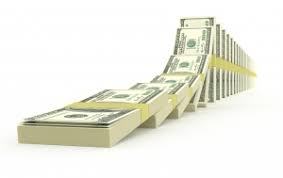

In [14]:
!pip install catboost --quiet

Instalación e importanción de las bibliotecas necesarias

In [15]:
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor

Se descarga el archivo CSV con los datos de Internet y se pasa a un dataframe

In [16]:
URL = "https://raw.githubusercontent.com/damalialutfiani/Salary-Dataset-Project/refs/heads/main/salary-dataset.csv"
df = pd.read_csv(URL, index_col=0)
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Developer,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Developer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 552 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           552 non-null    int64 
 1   experience_level    552 non-null    object
 2   employment_type     552 non-null    object
 3   job_title           552 non-null    object
 4   salary              552 non-null    int64 
 5   salary_currency     552 non-null    object
 6   salary_in_usd       552 non-null    int64 
 7   employee_residence  552 non-null    object
 8   remote_ratio        552 non-null    int64 
 9   company_location    552 non-null    object
 10  company_size        552 non-null    object
dtypes: int64(4), object(7)
memory usage: 51.8+ KB


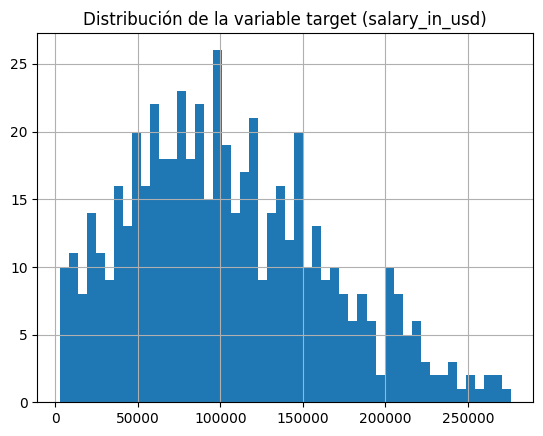

In [18]:
# Miramos la distribución de la variable target (salary_in_usd)
df['salary_in_usd'].hist(bins=50)
plt.title('Distribución de la variable target (salary_in_usd)')
plt.show()

Preprocesamiento básico de los datos

In [19]:
# Drop not relevant features
df.drop(['salary_currency', 'salary'], axis=1, inplace=True)

# Get categorical columns (except the target)
categorical_cols = [c for c in df.columns if df[c].dtype == 'object'] # categorical data
categorical_cols

['experience_level',
 'employment_type',
 'job_title',
 'employee_residence',
 'company_location',
 'company_size']

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 552 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           552 non-null    int64 
 1   experience_level    552 non-null    object
 2   employment_type     552 non-null    object
 3   job_title           552 non-null    object
 4   salary_in_usd       552 non-null    int64 
 5   employee_residence  552 non-null    object
 6   remote_ratio        552 non-null    int64 
 7   company_location    552 non-null    object
 8   company_size        552 non-null    object
dtypes: int64(3), object(6)
memory usage: 43.1+ KB


## **Algoritmo de Regresion Lineal (baseline)**

In [21]:
scaler = StandardScaler()

X = df.drop(categorical_cols + ['salary_in_usd'], axis=1)
X = scaler.fit_transform(X)  # Standardization

y = df['salary_in_usd'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
# Se crea y entrena el modelo Logistic Regression
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [23]:
# Se testea el modelo

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Metricas de performance
print("R2:", r2)
print("RMSE:", rmse)

R2: 0.08463047981925853
RMSE: 55694.09295969655


## **Algoritmo CatBoost**

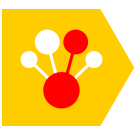

Separación entre datos de entrenamiento y datos de testeo

In [24]:
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
# Se entrena el modelo
model = CatBoostRegressor(random_seed=3, cat_features=categorical_cols)
model.fit(X_train, y_train, silent=True)

y_pred = model.predict(X_test)

In [26]:
# Se testea el modelo

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Metricas de performance
print("R2:", r2)
print("RMSE:", rmse)

R2: 0.5197175133584647
RMSE: 40342.17295789475


In [27]:
model_path = "regression_catboost_model.cbm"
model.save_model(model_path)

In [28]:
df_test = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_test = df_test.join(X_test.reset_index(drop=True)) # Join X_test to df_test
df_test = df_test.replace(float('nan'), np.nan).dropna() # Remove rows with null values
df_test

,y_test,y_pred,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
84,153667,110049.792907,2022.0,SE,FT,Data Engineer,US,100.0,US,M
144,100000,126865.564397,2021.0,MI,FT,Data Engineer,RO,0.0,US,L
82,54238,85548.071308,2021.0,MI,CT,Data Engineer,US,100.0,US,L
85,28476,53568.215688,2020.0,MI,FT,Data Scientist,FR,50.0,FR,S
10,51321,20005.272100,2021.0,SE,FT,Data Scientist,US,100.0,FR,L
...,...,...,...,...,...,...,...,...,...,...
130,100000,42944.901388,2022.0,SE,FT,Data Analyst,US,100.0,US,M
179,5679,42469.886878,2021.0,MI,FT,Data Scientist,US,100.0,US,L
32,68428,108486.200705,2021.0,SE,FT,Data Analyst,US,0.0,US,L
117,40189,44562.134782,2020.0,MI,FT,Data Scientist,ES,100.0,ES,M


In [29]:
# Load the model

loaded_model = CatBoostRegressor()
loaded_model.load_model(model_path)

y_pred = loaded_model.predict(X_test)
y_pred

array([138953.82842181, 110049.79290677, 126865.56439667,  85548.07130798,
       145802.27094868, 138953.82842181,  73345.09728021,  21903.2561086 ,
        53568.21568823, 138953.82842181, 150988.53880208,  20005.27209973,
        11729.13760887, 103476.23288717, 108166.59547821, 109682.04268802,
       136664.37839314, 172954.25027334, 103883.83366506,  46864.53718344,
        71759.84568591, 112572.06844011, 129937.58618183,  42878.96677304,
       129937.58618183, 140366.92212391,  85139.75042661, 114090.02017128,
       136664.37839314, 116353.69767976, 136664.37839314,  93169.55173468,
       161987.98402359, 130152.79778345,  99784.55686527, 146876.79876713,
       149874.35023693,  35289.26808106,  91349.97392715, 126865.56439667,
        68538.58361357, 138953.82842181, 109682.04268802,  22534.49190783,
       109682.04268802, 125413.05928922,  61853.89773053, 138953.82842181,
       138953.82842181, 136664.37839314,  87551.7635963 , 132754.04474099,
       150733.07379888,  

---